# Downloading the dataset


In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240616%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240616T130429Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db6618ac286e194b9825441dfcddfa74aff5bd9f7bb36034196414ba852414454685ece7bf64cbe05e0d872979021a9ce254e44508e9be91f111824aa0124fe749c5987841dcc627d86fb521dfbea5c4de477b6755f40b7394d0edaf0e246c77728f6bd9e082b4ef9341d186924784b1e366372dbe86d3a63b098873686dfca2eed043242fd14741de9a606edc98af1871fbe110542304b8b4476ed15808e75b599261db8535e5d2a147b655c086a7bd6a69818aa8490a6a3d02e9baa2e4e3997c4652c6ec25afcc6322fcb4f262b1d5b414c9de32ecbf95fc89dae08fda0648fe4f99b990a1002b68e4a52a7f0b9c0dffde3def27ebf08d6bd7352a6e36bafd1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103633768 bytes downloaded
Downloaded and uncompressed: heartbeat
Data source import complete.


In [ ]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report
import seaborn as sns

import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [6]:
train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

In [7]:
# test[test[187] == 4]
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [10]:
train.shape

(87554, 188)

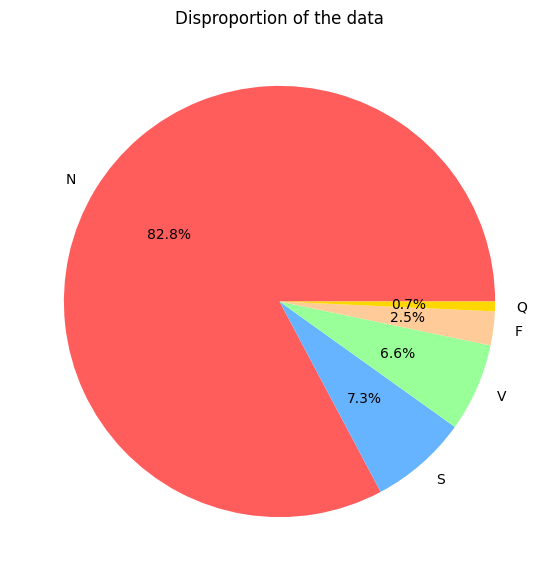

In [11]:
plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']
)
plt.title('Disproportion of the data')
plt.show()

In [12]:
random_seed = 42  # You can choose any integer value

df_0=(train[train[187]==0]).sample(n=20000,random_state=42)
df_1=train[train[187]==1]
df_2=train[train[187]==2]
df_3=train[train[187]==3]
df_4=train[train[187]==4]


df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=random_seed+1)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=random_seed+2)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=random_seed+3)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=random_seed+4)

train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

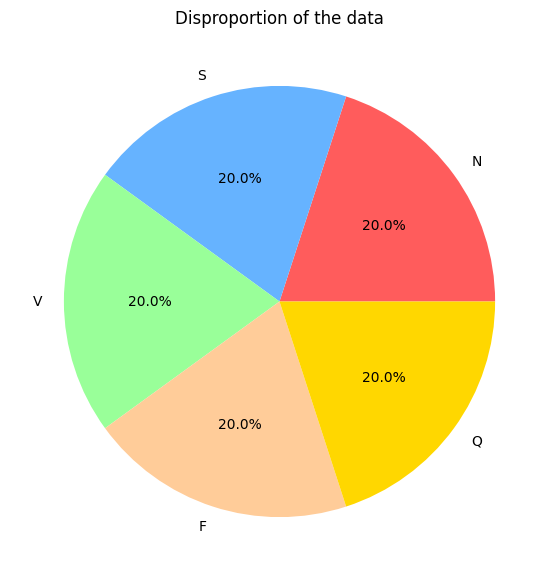

In [13]:
plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train[187].value_counts(), labels=['N', 'S', 'V', 'F', 'Q'], autopct='%1.1f%%', colors = ['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']
)
plt.title('Disproportion of the data')
plt.show()

In [14]:
X_train, y_train = train.iloc[:, :187], train[187]
X_test, y_test = test.iloc[:, :187], test[187]

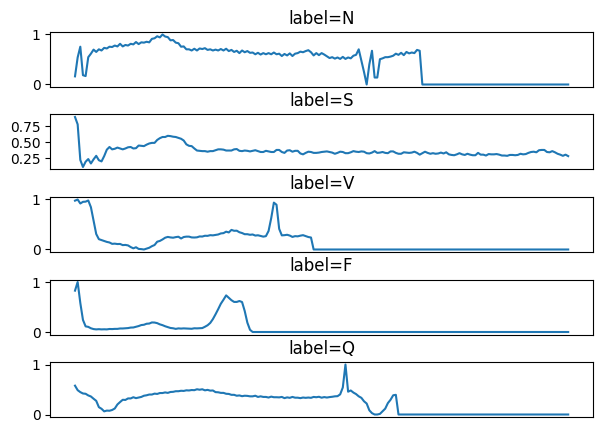

In [15]:
labels = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
fig, ax = plt.subplots(5,1, figsize=(7,5), gridspec_kw={'hspace': 0.5})
for i in range(5):
    ax[i].plot(X_train[y_train==i].iloc[0])
    ax[i].set_title(f'label={labels[i]}')
    ax[i].set_xticks([])

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [17]:
(X_train.shape[1],1)

(187, 1)

In [18]:
model = Sequential([
    Input(shape=(X_train_norm.shape[1], 1)),
    Conv1D(128, 11, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, 3, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, 3, activation='relu', padding='Same'),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='linear'),
    Dense(5, activation='linear')
])


In [19]:
model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True))

In [20]:
model.fit(X_train_norm, y_train, epochs=1, batch_size=32)

3125/3125 [==============================] - 31s 6ms/step - loss: 0.2284


# xAI

## Explainers when input is 2 dimensional



1/1 [==============================] - 0s 21ms/step
X_test   (187,) (100, 187)
7569/7569 [==============================] - 16s 2ms/step
shap_values   (187, 5)
colors   (187, 3)


<ipython-input-26-4a69f7130edf>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='SHAP value')


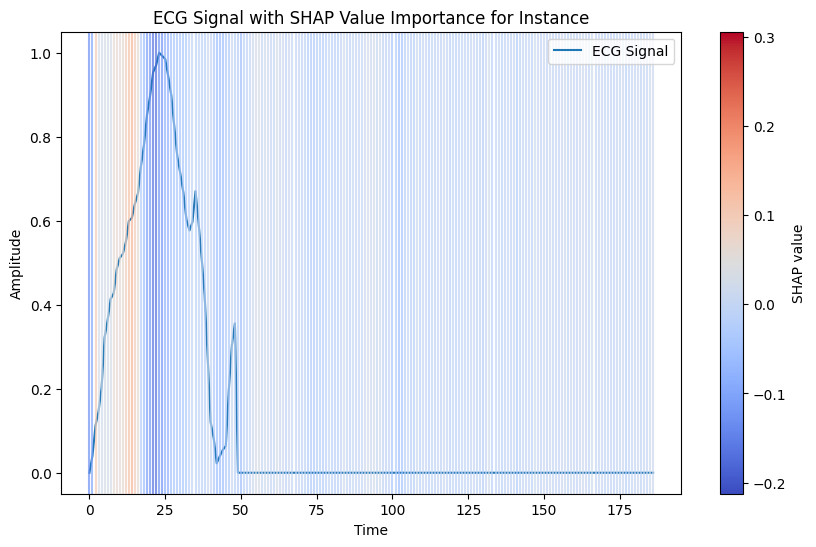

In [26]:
def visualize_shap_for_instance(model, X_train, X_test,k):


  background_data = X_train.sample(n=100, random_state=42).values  # Use `.values` to convert DataFrame to NumPy array
  print("X_test  ", X_test.shape, background_data.shape)
  explainer = shap.KernelExplainer(model.predict, background_data)
  shap_values = explainer.shap_values(X_test)  # Get SHAP values for required test instance

  print("shap_values  ", shap_values.shape)
  # Plot the ECG signal
  plt.figure(figsize=(10, 6))
  plt.plot(X_test, label='ECG Signal')

  # Color map to highlight important features
  cmap = plt.get_cmap('coolwarm')
  norm = plt.Normalize(vmin=np.min(shap_values), vmax=np.max(shap_values))
  colors = cmap(norm(shap_values))
  print("colors  ", colors[:,k,:3].shape)
  for i in range(len(X_test)):
    plt.axvline(x=i, color=colors[i,0,:3], alpha=0.7)

  plt.title(f'ECG Signal with SHAP Value Importance for Instance')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='SHAP value')
  plt.legend()
  plt.show()


k = 18674
l = model.predict(np.expand_dims(X_test_norm[k], 0)).argmax(axis=1)[0]
visualize_shap_for_instance(model, X_train, X_test.values[k,:],l)


1/1 [==============================] - 0s 33ms/step
2
X_test   (187,)
7569/7569 [==============================] - 16s 2ms/step
shap_values   (187, 5)
colors   (187, 3)


<ipython-input-21-b7e68bb6c3e5>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='SHAP value')


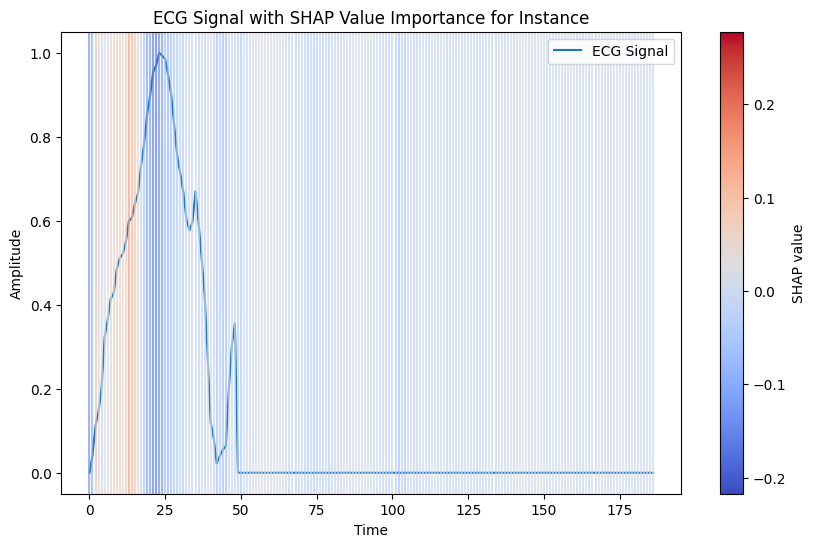

In [22]:
k = 18674
l = model.predict(np.expand_dims(X_test_norm[k], 0)).argmax(axis=1)[0]
print(l)
visualize_shap_for_instance(model, X_train, X_test.values[k,:],l)

1/1 [==============================] - 0s 76ms/step
1
X_test   (187,)
7569/7569 [==============================] - 22s 3ms/step
shap_values   (187, 5)
colors   (187, 3)


<ipython-input-21-b7e68bb6c3e5>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='SHAP value')


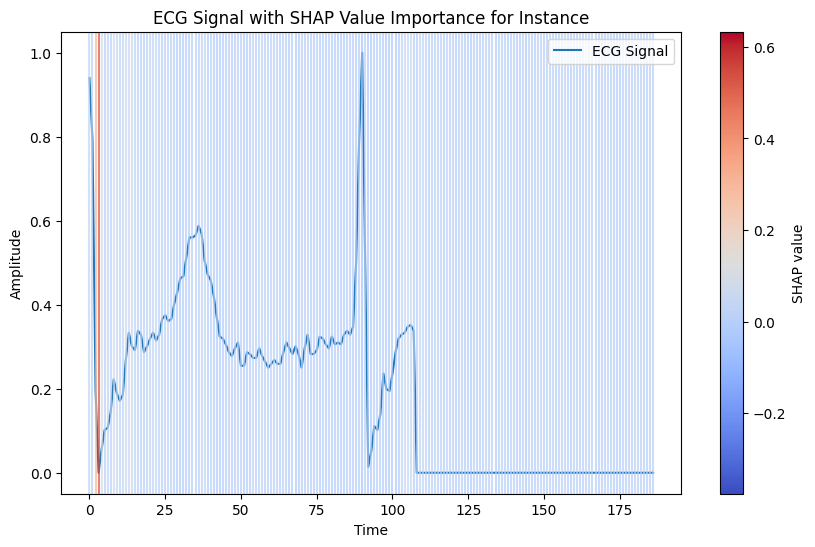

In [23]:
k = 18122
l = model.predict(np.expand_dims(X_test_norm[k], 0)).argmax(axis=1)[0]
print(l)
visualize_shap_for_instance(model, X_train, X_test.values[k,:],l)

k = 20285
l = model.predict(np.expand_dims(X_test_norm[k], 0)).argmax(axis=1)[0]
print(l)
visualize_shap_for_instance(model, X_train, X_test.values[k,:],l)

k = 18000
l = model.predict(np.expand_dims(X_test_norm[k], 0)).argmax(axis=1)[0]
print(l)
visualize_shap_for_instance(model, X_train, X_test.values[k,:],l)

In [ ]:
import scipy
import matplotlib.pyplot as plt
import numpy as np

def visualize_shap_for_instance(model, X_train, X_test, k):
    background_data = X_train.sample(n=100, random_state=42).values  # Use `.values` to convert DataFrame to NumPy array
    print("X_test  ", X_test.shape)
    explainer = shap.KernelExplainer(model.predict, background_data)
    shap_values = scipy.special.softmax(np.abs(explainer.shap_values(X_test)))  # Get SHAP values for required test instance

    print("shap_values  ", shap_values.shape)

    # Plot the ECG signal
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, label='ECG Signal')

    # Color map to highlight important features
    cmap = plt.get_cmap('Reds')
    norm = plt.Normalize(vmin=np.min(shap_values), vmax=np.max(shap_values))
    colors = cmap(norm(shap_values))

    # Create a background gradient
    for i in range(len(X_test)):
        plt.axvspan(i, i + 1, color=colors[i, k, :3], alpha=0.3)

    plt.plot(X_test, label='ECG Signal', color='black', linewidth=1.5)

    plt.title(f'ECG Signal with SHAP Value Importance for Instance')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='SHAP value')
    plt.legend()
    plt.show()

k = 18156
l = model.predict(np.expand_dims(X_test_norm[1], 0)).argmax(axis=1)[0]
print(l)
visualize_shap_for_instance(model, X_train, X_test.values[k, :], l)


In [ ]:
k = 20000
l = model.predict(np.expand_dims(X_test_norm[1], 0)).argmax(axis=1)[0]
print(l,y_test[k])
visualize_shap_for_instance(model, X_train, X_test.values[k, :], l)

k = 20009
l = model.predict(np.expand_dims(X_test_norm[1], 0)).argmax(axis=1)[0]
print(l,y_test[k])
visualize_shap_for_instance(model, X_train, X_test.values[k, :], l)

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to visualize SHAP values for the ith instance
def visualize_shap_for_instance(model, X_train, X_test, instance_index):
    background_data = X_train.sample(n=100, random_state=42).values

    explainer = shap.KernelExplainer(model.predict, background_data)

    X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test   # If X_test is a DataFrame, convert it to a NumPy array

    shap_values = explainer.shap_values(X_test_array[instance_index].reshape(1, -1))[0]
    ecg_signal = X_test_array[instance_index]

    # Normalize the SHAP values for color mapping
    norm = plt.Normalize(vmin=np.min(shap_values), vmax=np.max(shap_values))
    colors = plt.cm.coolwarm(norm(shap_values))

    # Create the gradient background
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ecg_signal, label='ECG Signal')
    for i in range(len(ecg_signal) - 1):
        ax.fill_betweenx([0, 1], i, i+1, color=colors[i], alpha=0.5, transform=ax.get_xaxis_transform())

    plt.title(f'ECG Signal with SHAP Value Importance for Instance {instance_index}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), label='SHAP value')
    plt.legend()
    plt.show()

# Example usage
k = 0  # Replace with the index of the instance you want to visualize
visualize_shap_for_instance(model, X_train, X_test, k)
